In [13]:
import pandas as pd
import numpy as np 
from io import StringIO
from typing import Dict
from sklearn.ensemble import RandomForestRegressor
import numpy as np

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import time
def string_to_pandas(text):
    stringio = StringIO(text[1])
    df = pd.read_csv(stringio).drop('Unnamed: 0', axis=1)
    return get_keys(text[0]), df

def get_keys(x):
    try:
        name = os.path.basename(x)
        return "".join([s for s in name if s.isdigit()])
    except (IndexError, KeyError):
        return '', ''
    
def concat(x, gene_expression_train_bc, gene_expression_validation_bc):
    
    train = x[1][0][1]
    train["train"] = 1
    
    val = x[1][1][1]
    val["train"] = 0
    train = pd.concat([train, gene_expression_train_bc.value], axis=1)
    val = pd.concat([val, gene_expression_validation_bc.value], axis=1)

    return pd.concat([train, val], axis=0, ignore_index=True)    


def read_gene_expression (training_set_f, validation_set_f):
   
    gene_expression_train = spark.read.option("header", True).csv(training_set_f).toPandas()
    gene_expression_validation = spark.read.option("header", True).csv(validation_set_f).toPandas()

    cols = [ "" + c for c in gene_expression_train.columns.tolist()]
    cols[0] = "name"
    gene_expression_train.columns = cols
    
    cols = [ "" + c for c in gene_expression_validation.columns.tolist()]
    cols[0] = "name"
    gene_expression_validation.columns = cols
    return gene_expression_train, gene_expression_validation

def read_feature_list(feature_list_f):
    
    feature_list = spark.read.option("header", True).csv(feature_list_f).toPandas()
    target = feature_list[feature_list['class'] == 'target']['feature_name'].values[0]
    feature_list = feature_list[(feature_list['class'] != "target")]
    feature_list = feature_list[(feature_list['class'] != "technical")]
    return target, feature_list


def get_joined_rdd(training_set_dir, validation_set_dir, gene_expression_train, gene_expression_validation):
    
    
    validation_rdd = sc.wholeTextFiles(training_set_dir+"/*", minPartitions=500)
    training_rdd = sc.wholeTextFiles(validation_set_dir+"/*", minPartitions=500)

    gene_expression_train_bc = sc.broadcast(gene_expression_train)
    gene_expression_validation_bc = sc.broadcast(gene_expression_validation)
    
    validation_rdd2 = validation_rdd.map(lambda x: string_to_pandas(x)).keyBy(lambda x: get_keys(x[0]))
    training_rdd2 = training_rdd.map(lambda x: string_to_pandas(x)).keyBy(lambda x: get_keys(x[0]))
    joined_rdd = training_rdd2.join(validation_rdd2, numPartitions=500).map(lambda x: concat(x, gene_expression_train_bc, gene_expression_validation_bc))

    train = training_rdd2.take(1)[0]

    test = validation_rdd2.take(1)[0]
    t = joined_rdd.take(1)[0]
    
    return joined_rdd


def predict_rdd(data, target, features, clf):
    data = data.apply(pd.to_numeric, errors="ignore")
    data[target] = np.log(data[target])
    if data.shape[0] < 10:
        return []

    data = data.reset_index(drop=True)
    data_train = data[data["train"] == 1]
    data_test  =  data[(data["train"] == 0)]

    data_train = data_train.replace([np.inf, -np.inf], np.nan)
    data_test = data_test.replace([np.inf, -np.inf], np.nan)
    data_train = data_train.dropna(subset=features+[target])
    data_test = data_test.dropna(subset=features+[target])
    
    
    importances = []
    if data_test.shape[0] > 0:
        num_training = data_train.shape[0]
        df = pd.get_dummies(pd.concat([data_train, data_test])[features])

        X_train = df.iloc[:num_training, :]
        X_test = df.iloc[num_training:, :]

        y_train = data_train[target].values.ravel()
        y_test = data_test[target].values.ravel()

        clf.fit(X_train, y_train)
        prediction = clf.predict(X_test)
        data_test["prediction"] = np.exp(prediction)
        data_test["prediction_actual"] = np.exp(y_test)
        feature_imp = pd.Series(clf.feature_importances_)
        feature_imp.index = X_test.columns

        importances.append(feature_imp)
        for r in range (0, 0):
            np.random.shuffle(y_train)
            clf.fit(X_train, y_train)
            prediction = clf.predict(X_test)
            feature_imp = pd.Series(clf.feature_importances_)
            feature_imp.index = X_test.columns
            importances.append(feature_imp)
            data_test["prediction_{}".format(r)] = np.exp(prediction)
        return [data_test.filter(regex="prediction*"), pd.DataFrame(importances)]
    return []


def run_prediction(joined_rdd, features, clf, target):
    forecast_rdd = joined_rdd.map(lambda x: predict_rdd(x, target, features, clf))
    pred = forecast_rdd.collect()
    results_pred = []
    for k, p in enumerate(pred):
        pred = p[0]
        pred["imputation_set"] = k
        results_pred.append(pred)
    results_pred = pd.concat(results_pred)
    results_pred["error"] = ((results_pred["prediction_actual"] - results_pred["prediction"]))
    results_pred["error_abs"] = np.abs(results_pred["error"])
    return results_pred


def experiment(joined_rdd, target, features, clf):
    features = features['feature_name'].values.tolist()
    forecast_rdd = joined_rdd.map(lambda x: predict_rdd(x, target, features, clf))
    predictions = forecast_rdd.collect()
    results_pred = []
    importances = []
    for i, p in enumerate(predictions):
        pred = p[0]
        impor = p[1]
        pred["imputation_set"] = i
        impor["imputation_set"] = i
        importances.append(impor)
        results_pred.append(pred)
        
    results_pred = pd.concat(results_pred)
    importances = pd.concat(importances)
    
    importances_median = pd.DataFrame(importances.drop("imputation_set", axis=1).mean(), columns=
                                 ['value'])
    importances_median = importances_median.sort_values("value", ascending=False)
    importances_median['rank'] = range(1, importances_median.shape[0]+1)
    importances_median['decile'] = np.digitize(importances_median['rank'], np.percentile(importances_median['rank'], np.arange(0, 100, 10)))
    return results_pred, importances_median

def test_deciles(joined_rdd, importances, clf, target):
    predictions_by_groups = []
    groups_deciles =  importances.groupby('decile')
    for g in groups_deciles:
        genes_to_test = g[1].index.tolist()
        results_pred = run_prediction(joined_rdd, genes_to_test, clf, target)
        results_pred["decile"] = g[0]
        predictions_by_groups.append(results_pred)
    predictions_by_groups = pd.concat(predictions_by_groups)
    predictions_by_groups["error"] = ((predictions_by_groups["prediction_actual"] - predictions_by_groups["prediction"]))
    return predictions_by_groups

In [14]:
gene_expression_train_f = "gs://conrad-project/Input_files_for_new_analysis_13-06-18/training_set_gene_expression_COMBAT.csv"
gene_expression_validation_f = "gs://conrad-project/Input_files_for_new_analysis_13-06-18/validation_set_gene_expression_COMBT.csv"

training_set_dir = "gs://conrad-project/Input_files_for_new_analysis_13-06-18/imputation_sets/train_combat_13_04_18/"
validation_set_dir = "gs://conrad-project/Input_files_for_new_analysis_13-06-18/imputation_sets/validation_combat_13_04_18/"

feature_list_f = "gs://conrad-project/Input_files_for_new_analysis_13-06-18/feature_lists/features_warddays_CI.csv"

1530125124.6135545

In [ ]:
gene_expression_train, gene_expression_validation = read_gene_expression (gene_expression_train_f, gene_expression_validation_f)
data_joined_rdd = get_joined_rdd(training_set_dir, validation_set_dir, gene_expression_train, gene_expression_validation)
clf = RandomForestRegressor(n_estimators=10,  max_features='auto', max_leaf_nodes=None, bootstrap=True,
                                oob_score=True, n_jobs=-1, random_state=None,
                                verbose=0, warm_start=True)
target, feature_list = read_feature_list(feature_list_f)
results_pred, importances = experiment(data_joined_rdd, target, feature_list, clf)
results_deciles = test_deciles(data_joined_rdd, importances, clf, target)


In [3]:
file = "gs://conrad-project/results/{}/predictions.csv".format(str(time.time()))

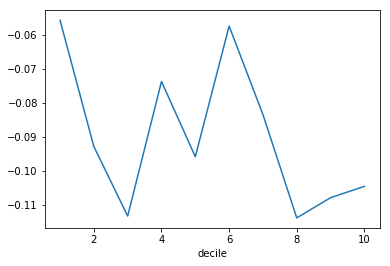

In [6]:
results_deciles.groupby(["decile"]).apply(lambda x: metrics.r2_score(x["prediction_actual"],x["prediction"])).plot()

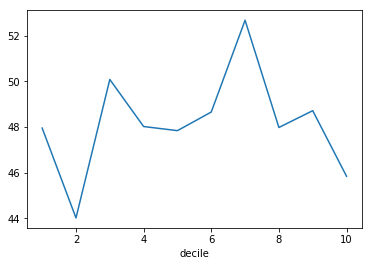

In [23]:
results_deciles.groupby(["decile"]).apply(lambda x: metrics.median_absolute_error(x["prediction_actual"],x["prediction"])).plot()

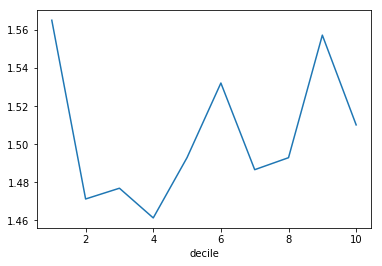

In [24]:
results_deciles.groupby(["decile"]).apply(lambda x: metrics.mean_squared_log_error(x["prediction_actual"],x["prediction"])).plot()

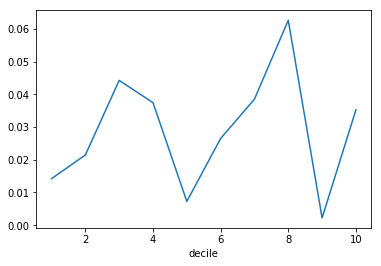

In [25]:
results_deciles.groupby(["decile"]).apply(lambda x: metrics.explained_variance_score(x["prediction_actual"],x["prediction"])).plot()